In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Simple Logistic Regression (Classification Task, 2 Parameters)

# Gennerating Sample Dataset

Simple 2-class dataset in 2D: <br>
Class 1 is "positive" or "+1" <br>
Class 2 is "negative" or "-1" <br>
Each point is point X is generated from a normal distrubution with mean [2,2] or [-2,-2] and variance (0.7). $N([2,2],cov)$ <br>
We then stack all the points in training data and test data and label them as '+1' or '-1'.

Train shape: (200, 2) Test shape: (200, 2)


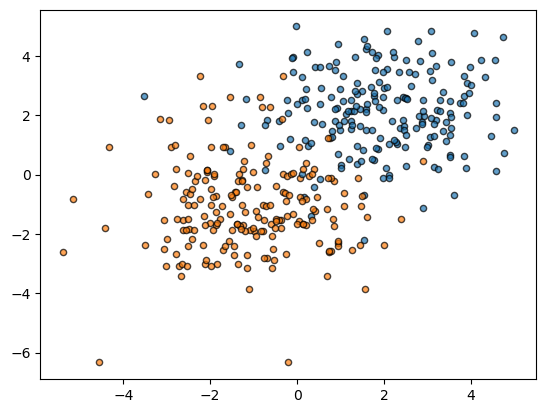

In [31]:
rng = np.random.default_rng(0)

N_train = 100
N_test  = 100

mean_pos = np.array([2.0, 2.0])
mean_neg = np.array([-1.0, -1.0])
cov = 2 * np.eye(2)

X_pos = rng.multivariate_normal(mean_pos, cov, size=N_train)
X_neg = rng.multivariate_normal(mean_neg, cov, size=N_train)
X_train = np.vstack([X_pos, X_neg])
y_train = np.hstack([np.ones(N_train), -np.ones(N_train)])  # {+1, -1}

X_pos_t = rng.multivariate_normal(mean_pos, cov, size=N_test)
X_neg_t = rng.multivariate_normal(mean_neg, cov, size=N_test)
X_test = np.vstack([X_pos_t, X_neg_t])
y_test = np.hstack([np.ones(N_test), -np.ones(N_test)])

N, D = X_train.shape
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1], c='C0', edgecolor='k', s=20, alpha=0.7)
plt.scatter(X_test[y_test==-1,0], X_train[y_test==-1,1], c='C1', edgecolor='k', s=20, alpha=0.7)
plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='C0', edgecolor='k', s=20, alpha=0.7)
plt.scatter(X_train[y_train==-1,0], X_train[y_train==-1,1], c='C1', edgecolor='k', s=20, alpha=0.7)

# Sampling Algorithms

## Calculating Gradient of log-likehoods

### MCMC Langevin Dynamics

$$ \theta_{t+1} = \theta_t + \frac{\epsilon_t}{2}(\nabla \log p(\theta_t)+\sum_{i=1}^{N}\nabla \log p(y_i | x_i,\theta_t)) + \eta_t $$

where: $ \eta_t \sim N(0, \epsilon_t)$

### Algorithm SGLD: 

$$ \theta_{t+1} = \theta_t + \frac{\epsilon_t}{2}(\nabla \log p(\theta_t)+\frac{N}{n}\sum_{i \in B_t}\nabla \log p(y_i | x_i, \theta_t)) + \eta_t $$

where: $ \eta_t \sim N(0, \epsilon_t)$ random noise, $ \epsilon_t $ stepsize, minibatch size $ n=1 $

In [32]:
sigma0_sq = 10.0  # prior variance

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def grad_log_prior(theta):
    return -theta / sigma0_sq

def grad_log_lik_full(theta, X, y):
    z = y * (X @ theta) # Ease of notation
    return (X.T @ (y * (1.0 - sigmoid(z))))

def grad_log_lik_minibatch(theta, X_batch, y_batch, N_total):
    m = len(y_batch)
    z = y_batch * (X_batch @ theta)
    g_batch = X_batch.T @ (y_batch * (1.0 - sigmoid(z)))
    return (N_total / m) * g_batch

# Unsure of purpose
def accuracy_from_theta(theta, X, y):
    preds = np.sign(X @ theta)
    return (preds == y).mean()

$p(\theta)$ is the prior, we can use a gaussian prior standard in ML: $$p(\theta) = N(0, \sigma_0^2)$$ 

Mean 0 as no bias to say wether parameter is positive or negative. High Variance essentially sayoing we don't really know. (Tbh just a standard in the 2011 paper $\theta \sim N(0,\sigma^2)).$

$$ \nabla \log p(\theta) = \frac{1}{\sigma_0^{2}}\theta$$

For a single datapoint ($ x_i, y_j$): $$ p(y_i|x_i, \theta) = \sigma(y_i \theta^T x_i) $$
Take the gradient of the loglikehood: $$ \nabla_{\theta} \log p(y_i|x_i, \theta) = \sigma(1 -y_i \theta^T x_i)y_ix_i$$
Do Summation In this case equivalnat to Matrix Multiplication: $$ \nabla \log p(y_i | x_i, \theta_t) = X^T(y(1-\sigma(y(X \theta))))$$

## LMC

$\epsilon$ is constant. <br>

2 types of LMC algorithms
1) With Metropolis Hastings Step: Metropolis Adjusted Langevin Algoritm (MALA), 
2) Without Metropolis Hastings Step: Unadjusted Langevin Algorithm (ULA), 

### ULA

In [33]:
def run_ula(X, y, T=20000, eps=5e-4, seed=0):
    rng = np.random.default_rng(seed)
    N, D = X.shape
    theta = np.zeros(D) # Ini
    samples = []

    for t in range(T):
        g_lik = grad_log_lik_full(theta, X, y)
        g_prior = grad_log_prior(theta)
        g = g_lik + g_prior  # ∇ log posterior

        noise = np.sqrt(eps) * rng.normal(size=theta.shape)
        # LMC update: w_{t+1} = w_t + (ε/2) g + sqrt(ε) ξ
        theta = theta + 0.5 * eps * g + noise

        samples.append(theta.copy())

    return np.array(samples)

### MALA

In [36]:
def log_lik(theta, X, y):
    z = y * (X @ theta)
    return np.sum(-np.log(1 + np.exp(-z)))   # log σ(z) = -log(1+exp(-z))


def log_prior(theta, sigma0_sq=10.0):
    return -0.5 * np.sum(theta**2) / sigma0_sq


def log_posterior(theta, X, y, sigma0_sq=10.0):
    return log_lik(theta, X, y) + log_prior(theta, sigma0_sq)


In [37]:
def run_mala(X, y, T=20000, eps=5e-3, seed=0):

    rng = np.random.default_rng(seed)
    N, D = X.shape
    theta = np.zeros(D)  # init
    samples = []
    accepts = 0

    # log posterior at current θ
    log_post = log_posterior(theta, X, y)

    for t in range(T):
        # ----- 1. Gradient at current θ -----
        g_lik = grad_log_lik_full(theta, X, y)
        g_prior = grad_log_prior(theta)
        g = g_lik + g_prior  # ∇ log π(θ)

        # ----- 2. Forward proposal: θ' ~ N( θ + (ε/2)g, ε I ) -----
        mean_forward = theta + 0.5 * eps * g
        theta_prop = mean_forward + np.sqrt(eps) * rng.normal(size=theta.shape)

        # ----- 3. Log posterior at θ' -----
        log_post_prop = log_posterior(theta_prop, X, y)

        # ----- 4. Gradient at θ' (for reverse proposal) -----
        g_lik_prop = grad_log_lik_full(theta_prop, X, y)
        g_prior_prop = grad_log_prior(theta_prop)
        g_prop = g_lik_prop + g_prior_prop

        # backward proposal mean: q(θ | θ') = N( θ; θ' + (ε/2)∇ log π(θ'), ε I )
        mean_backward = theta_prop + 0.5 * eps * g_prop

        # ----- 5. Log proposal densities (up to constant) -----
        # log q(θ' | θ)
        log_q_forward = -0.5 / eps * np.sum((theta_prop - mean_forward)**2)
        # log q(θ | θ')
        log_q_backward = -0.5 / eps * np.sum((theta - mean_backward)**2)

        # ----- 6. MH acceptance log-ratio -----
        log_alpha = (log_post_prop + log_q_backward) - (log_post + log_q_forward)

        if np.log(rng.random()) < log_alpha:
            # accept
            theta = theta_prop
            log_post = log_post_prop
            accepts += 1

        # always store the current θ (accepted or not)
        samples.append(theta.copy())

    samples = np.array(samples)
    acc_rate = accepts / T
    
    return samples, acc_rate

## SGLD

SGLD cannot do Metroplois Hastings Step as it uses minibatches

In [38]:
def run_sgld(X, y, T=20000, eps0=1e-2, gamma=0.55, batch_size=10000, seed=1):
    rng = np.random.default_rng(seed)
    N, D = X.shape
    theta = np.zeros(D)
    samples = []

    indices = np.arange(N)
    t = 0

    while t < T:
        rng.shuffle(indices)

        # process whole dataset in minibatches
        for start in range(0, N, batch_size):
            t += 1
            if t > T:
                break

            batch_idx = indices[start:start + batch_size]
            Xb = X[batch_idx]
            yb = y[batch_idx]

            # scaling: (N / batch_size)
            g_lik = grad_log_lik_minibatch(theta, Xb, yb, N_total=N)
            g_prior = grad_log_prior(theta)
            g = g_lik + g_prior

            eps_t = eps0 * (t ** -gamma)
            noise = np.sqrt(eps_t) * rng.normal(size=theta.shape)

            theta = theta + 0.5 * eps_t * g + noise

            samples.append(theta.copy())

    return np.array(samples)


## MCMC Metroplois Hastings

In [39]:
def run_mh(X, y, T=20000, proposal_std=0.1,  seed=1):
   
    rng = np.random.default_rng(seed)
    N, D = X.shape
    theta = np.zeros(D)  # initial value
    samples = []
    accepts = 0

    # log posterior at current θ
    log_post = log_posterior(theta, X, y)

    for t in range(T):
        # ----- 1. Proposal: θ' ~ N(θ, proposal_std^2 I) -----
        theta_prop = theta + proposal_std * rng.normal(size=theta.shape)

        # ----- 2. Log posterior at θ' -----
        log_post_prop = log_posterior(theta_prop, X, y)

        # ----- 3. MH acceptance log-ratio (q cancels since proposal is symmetric) -----
        log_alpha = log_post_prop - log_post

        # ----- 4. Accept/reject -----
        if np.log(rng.random()) < log_alpha:
            theta = theta_prop
            log_post = log_post_prop
            accepts += 1

        # store current θ (accepted or not)
        samples.append(theta.copy())

    samples = np.array(samples)
    acc_rate = accepts / T
    return samples, acc_rate


# Run Experiment

In [40]:
T = 2000

samples_ula = run_ula(X_train, y_train, T=T, eps=5e-3, seed=0)
samples_ula.shape

(2000, 2)

In [41]:
samples_sgld = run_sgld(X_train, y_train, T=T, eps0=2e-1, gamma=0.55, batch_size = 2000, seed=0)
samples_sgld.shape

(2000, 2)

In [42]:
samples_mala = run_mala(X_train, y_train, T=T, eps=5e-3, seed=0)
samples_mala[0].shape

(2000, 2)

In [43]:
samples_mh = run_mh(X_train, y_train, T=T, proposal_std=0.05)
samples_mh[0].shape

(2000, 2)

In [44]:
# Discard burn-in
burn = T // 2
theta_ula_samples = samples_ula[burn:]
theta_sgld_samples = samples_sgld[burn:]

burn_small = T // 10
# These also need burn ins: Interesting to note MALA needs a much shorter burn in than MCMC as it uses gradients to approach correct dist.
theta_mala_samples = samples_mala[0][burn_small:]
theta_mh_samples = samples_mh[0][burn_small:]

print("ULA posterior mean:", theta_ula_samples.mean(axis=0))
print("SGLD posterior mean:", theta_sgld_samples.mean(axis=0))
print("MALA posterior mean:", theta_mala_samples.mean(axis=0))
print("MH posterior mean:", theta_mh_samples.mean(axis=0))

print("ULA test acc (mean theta):", accuracy_from_theta(theta_ula_samples.mean(axis=0), X_test, y_test))
print("SGLD test acc (mean theta):",accuracy_from_theta(theta_sgld_samples.mean(axis=0), X_test, y_test))
print("MAlA test acc (mean theta):",accuracy_from_theta(theta_mala_samples.mean(axis=0), X_test, y_test))
print("MH posterior (mean: theta)", accuracy_from_theta(theta_mh_samples.mean(axis=0), X_test, y_test))

ULA posterior mean: [1.42271367 1.25052076]
SGLD posterior mean: [1.49531849 1.26314655]
MALA posterior mean: [1.49514145 1.29019083]
MH posterior mean: [1.42895613 1.25726586]
ULA test acc (mean theta): 0.905
SGLD test acc (mean theta): 0.905
MAlA test acc (mean theta): 0.905
MH posterior (mean: theta) 0.905


In [45]:
print("ULA posterior standard deviation:", theta_ula_samples.std(axis=0))
print("SGLD posterior standard deviation:",  theta_sgld_samples.std(axis=0))
print("MALA posterior standard deviation:",  theta_mala_samples.std(axis=0))
print("MH posterior standard deviation:",  theta_mh_samples.std(axis=0))

ULA posterior standard deviation: [0.29114978 0.22810419]
SGLD posterior standard deviation: [0.23682044 0.26531709]
MALA posterior standard deviation: [0.30172025 0.28113424]
MH posterior standard deviation: [0.30857964 0.22212194]


## Uncertainity

Very Important Block of code gives uncertanity: Give a certain point (x,y) what is the proabilility that it is part of the class +1?

$$ p(y = 1| x, D) = \int\sigma(\theta^{k}x)$$
$$ p(y = 1| x) = \frac{1}{K}\sum_{i=1}^{K}\sigma(\theta^{k}x)$$

Essentially get the average chance based on all of your sample that the point will be in class +1 (mean prob).

What “entropy” means in your predictive uncertainty plots: This entropy measures how uncertain the model is at that point (x,y).

$$H(p) = -p\log(p) - (1 - p)\log(1-p)$$

In [46]:
def logit_predictive_prob(theta_samples, X):
   
    logits = X @ theta_samples.T
    probs = sigmoid(logits)              # σ(θ_k^T x_n)
    mean_prob = probs.mean(axis=1)       # average over samples

    eps = 1e-12
    ent = -mean_prob*np.log(mean_prob+eps) - (1-mean_prob)*np.log(1-mean_prob+eps) # eps is to avoid log(0)
    return mean_prob, ent

## Plot Marginal Posterior Distrubutions

Plot should not be used for diagnositc reason as only uses a small number of the total sample we collected. Variance value is actually a better measure.

In [47]:
theta_mala_samples[:,0].shape

(1800,)

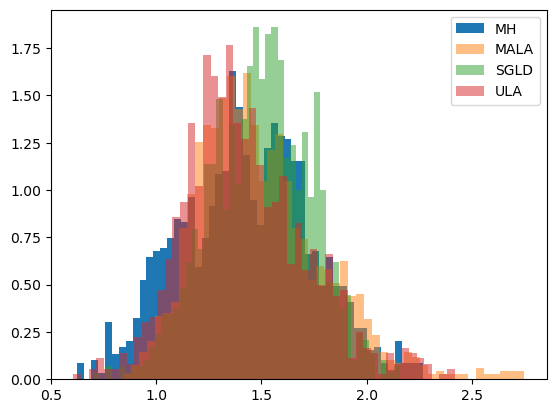

In [48]:
plt.hist(theta_mh_samples[:,0], bins=50, density=True, label="MH")
plt.hist(theta_mala_samples[:,0], bins=50, density=True, alpha=0.5, label="MALA")
plt.hist(theta_sgld_samples[:,0],  bins=50, density=True, alpha=0.5, label="SGLD")
plt.hist(theta_ula_samples[:,0],  bins=50, density=True, alpha=0.5, label="ULA")
plt.legend()

In [49]:
# 500 samples for computational effeciency
K_plot = 500
K_plot = min(500, theta_ula_samples.shape[0], theta_sgld_samples.shape[0])

theta_ula_sub  = theta_ula_samples[-K_plot:]   
theta_sgld_sub = theta_sgld_samples[-K_plot:]
theta_mala_sub = theta_mala_samples[-K_plot:]
theta_mh_sub = theta_mh_samples[-K_plot:]

# Grid in input space
xx, yy = np.meshgrid(np.linspace(-5, 5, 200), np.linspace(-5, 5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

# "LMC"/ULA predictive mean and entropy
mean_prob_ula, ent_ula = logit_predictive_prob(theta_ula_sub, grid)
mean_prob_ula = mean_prob_ula.reshape(xx.shape)
ent_ula = ent_ula.reshape(xx.shape)

# SGLD predictive mean and entropy
mean_prob_sgld, ent_sgld = logit_predictive_prob(theta_sgld_sub, grid)
mean_prob_sgld = mean_prob_sgld.reshape(xx.shape)
ent_sgld = ent_sgld.reshape(xx.shape)

# MALA predictive mean and entropy
mean_prob_mala, ent_mala = logit_predictive_prob(theta_mala_sub, grid)
mean_prob_mala = mean_prob_mala.reshape(xx.shape)
ent_mala = ent_mala.reshape(xx.shape)

# MH predictive mean and entropy
mean_prob_mh, ent_mh = logit_predictive_prob(theta_mh_sub, grid)
mean_prob_mh = mean_prob_mh.reshape(xx.shape)
ent_mh = ent_mh.reshape(xx.shape)

##  Plot predictive mean and uncertainty for both methods

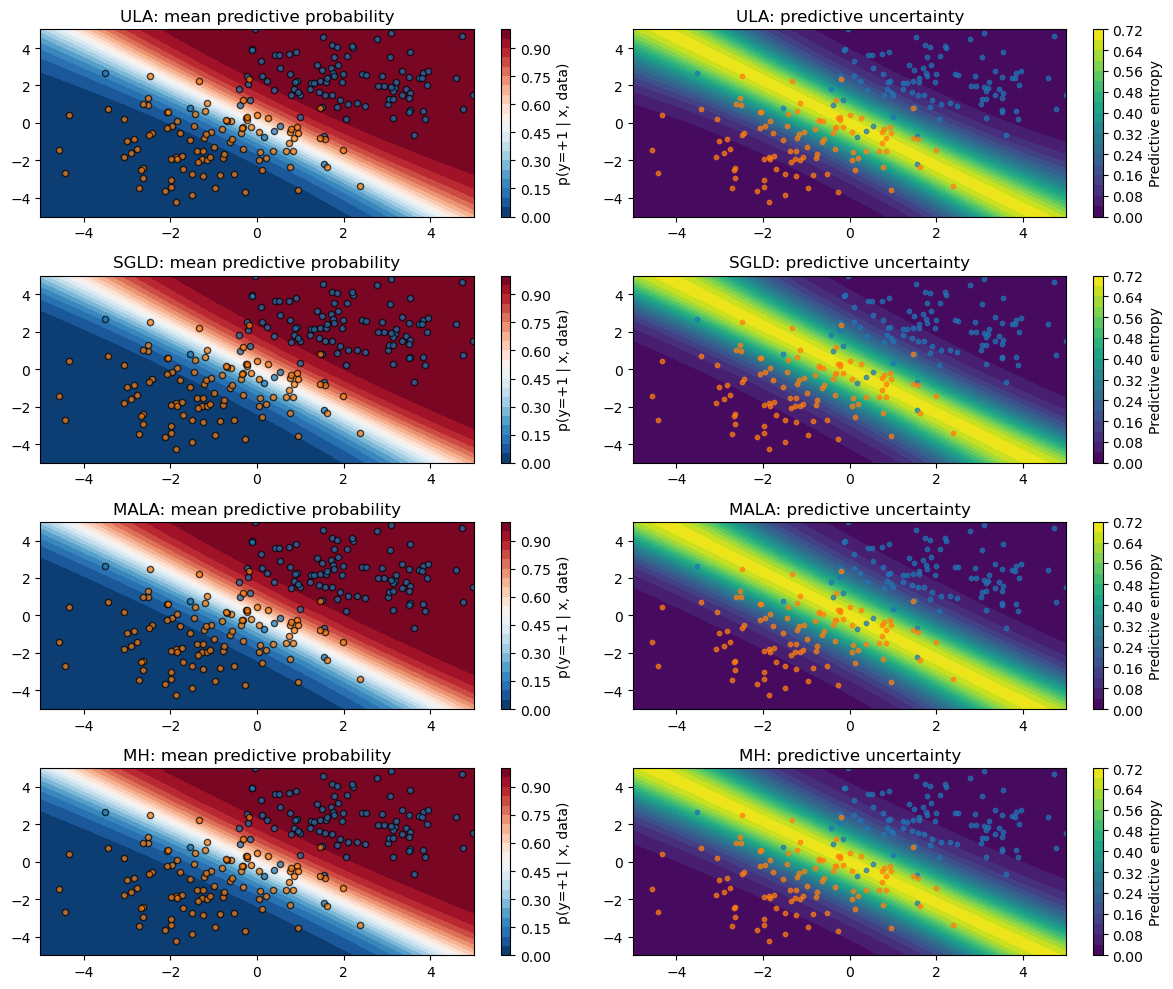

In [50]:
plt.figure(figsize=(12,10))

# ULA mean prediction
plt.subplot(4,2,1)
plt.contourf(xx, yy, mean_prob_ula, levels=20, cmap="RdBu_r", vmin=0, vmax=1)
plt.colorbar(label="p(y=+1 | x, data)")
plt.scatter(X_test[y_test==1,0],  X_test[y_test==1,1],  c='C0', edgecolor='k', s=20, alpha=0.7)
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], c='C1', edgecolor='k', s=20, alpha=0.7)
plt.title("ULA: mean predictive probability")

# ULA predictive entropy
plt.subplot(4,2,2)
plt.contourf(xx, yy, ent_ula, levels=20, cmap="viridis")
plt.colorbar(label="Predictive entropy")
plt.scatter(X_test[y_train==1,0],  X_test[y_train==1,1],  c='C0', s=10, alpha=0.7)
plt.scatter(X_test[y_train==-1,0], X_test[y_train==-1,1], c='C1', s=10, alpha=0.7)
plt.title("ULA: predictive uncertainty")

# SGLD mean prediction
plt.subplot(4,2,3)
plt.contourf(xx, yy, mean_prob_sgld, levels=20, cmap="RdBu_r", vmin=0, vmax=1)
plt.colorbar(label="p(y=+1 | x, data)")
plt.scatter(X_test[y_train==1,0],  X_test[y_test==1,1],  c='C0', edgecolor='k', s=20, alpha=0.7)
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], c='C1', edgecolor='k', s=20, alpha=0.7)
plt.title("SGLD: mean predictive probability")

# SGLD predictive entropy
plt.subplot(4,2,4)
plt.contourf(xx, yy, ent_sgld, levels=20, cmap="viridis")
plt.colorbar(label="Predictive entropy")
plt.scatter(X_test[y_test==1,0],  X_test[y_test==1,1],  c='C0', s=10, alpha=0.7)
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], c='C1', s=10, alpha=0.7)
plt.title("SGLD: predictive uncertainty")

# MALA mean prediction
plt.subplot(4,2,5)
plt.contourf(xx, yy, mean_prob_mala, levels=20, cmap="RdBu_r", vmin=0, vmax=1)
plt.colorbar(label="p(y=+1 | x, data)")
plt.scatter(X_test[y_test==1,0],  X_test[y_test==1,1],  c='C0', edgecolor='k', s=20, alpha=0.7)
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], c='C1', edgecolor='k', s=20, alpha=0.7)
plt.title("MALA: mean predictive probability")

# MALA predictive entropy
plt.subplot(4,2,6)
plt.contourf(xx, yy, ent_mala, levels=20, cmap="viridis")
plt.colorbar(label="Predictive entropy")
plt.scatter(X_test[y_test==1,0],  X_test[y_test==1,1],  c='C0', s=10, alpha=0.7)
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], c='C1', s=10, alpha=0.7)
plt.title("MALA: predictive uncertainty")

# MH mean prediction
plt.subplot(4,2,7)
plt.contourf(xx, yy, mean_prob_mh, levels=20, cmap="RdBu_r", vmin=0, vmax=1)
plt.colorbar(label="p(y=+1 | x, data)")
plt.scatter(X_test[y_test==1,0],  X_test[y_test==1,1],  c='C0', edgecolor='k', s=20, alpha=0.7)
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], c='C1', edgecolor='k', s=20, alpha=0.7)
plt.title("MH: mean predictive probability")

# MH predictive entropy
plt.subplot(4,2,8)
plt.contourf(xx, yy, ent_mh, levels=20, cmap="viridis")
plt.colorbar(label="Predictive entropy")
plt.scatter(X_test[y_test==1,0],  X_test[y_test==1,1],  c='C0', s=10, alpha=0.7)
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], c='C1', s=10, alpha=0.7)
plt.title("MH: predictive uncertainty")

plt.tight_layout()
plt.show()


# Run Time for Effective Samples (Hard to Tell without Parameter Fitting)

In [51]:
import arviz as az
import time

T = 2000

start = time.time()
theta_mala_samples, acc_mala = run_mala(X_train, y_train, T=T, eps=5e-3, seed=0)
end = time.time()

runtime_mala = end - start
print("MALA runtime (s):", runtime_mala)


samples = theta_mala_samples[np.newaxis, ...]                
idata = az.from_dict(posterior={"theta": samples})
ess_vals = az.ess(idata, var_names=["theta"], method="bulk")["theta"].values  # shape (D,)

ess_median = np.median(ess_vals)
ess_per_second_mala = ess_median / runtime_mala

print("ESS median:", ess_median)
print("ESS/sec (MALA, median ESS):", ess_per_second_mala)

MALA runtime (s): 0.06089186668395996
ESS median: 27.735017918868543
ESS/sec (MALA, median ESS): 455.47984368451716


In [52]:
start = time.time()
theta_mh_samples, acc_mh = run_mh(X_train, y_train, T=T, proposal_std=0.05)
end = time.time()

runtime_mh = end - start
print("MALA runtime (s):", runtime_mala)


samples = theta_mh_samples[np.newaxis, ...]                
idata = az.from_dict(posterior={"theta": samples})
ess_vals = az.ess(idata, var_names=["theta"], method="bulk")["theta"].values  # shape (D,)

ess_median = np.median(ess_vals)
ess_per_second_mala = ess_median / runtime_mala

print("ESS median:", ess_median)
print("ESS/sec (MALA, median ESS):", ess_per_second_mala)

MALA runtime (s): 0.06089186668395996
ESS median: 15.743917778286848
ESS/sec (MALA, median ESS): 258.55534795805636
